# Clustering — Model Building, Interpretation & Evaluation
Following CRISP-DM Phases 4 (Modelling) and 5 (Evaluation)

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

# Load pre-constructed clustering features
df = pd.read_csv('data/clustering_features_v3.csv')

# Load target variable from raw dataset
df_raw = pd.read_csv('CDC Diabetes Dataset (4).csv')
target = df_raw['Diabetes_012'].values

# 6 features — cardio_metabolic_risk and bmi_category excluded after sensitivity
# analysis showed removing them improves cluster quality while retaining diabetes separation
features = ['lifestyle_risk_score', 'limited_access_to_care', 'age_group',
            'income_bracket', 'education_bracket', 'perceived_health_risk']

print(f"Dataset: {df.shape[0]:,} records, {len(features)} features")
print(f"Target: {len(target):,} records")
print(f"\nFeature ranges:")
for col in features:
    print(f"  {col}: {df[col].min()}–{df[col].max()}")

Dataset: 253,680 records, 6 features
Target: 253,680 records

Feature ranges:
  lifestyle_risk_score: 0–4
  limited_access_to_care: 0–1
  age_group: 0–3
  income_bracket: 0–2
  education_bracket: 0–2
  perceived_health_risk: 0–4


## 4.1 Select Modelling Technique

### Modelling Technique

Four clustering algorithms are compared:

| Algorithm | Distance Metric | Best For |
|-----------|-----------------|----------|
| K-Means | Euclidean | Continuous data, interpretable centroids |
| Hierarchical (Ward) | Euclidean | Visualising cluster hierarchy |
| DBSCAN | Euclidean | Density-based clusters, automatic k selection |
| Hierarchical (Gower) | Gower | Mixed ordinal/binary data |

**Primary choice: K-Means** — provides interpretable centroids describing the "average patient" in each segment, and a fixed number of clusters suitable for public health campaigns.

### Modelling Assumptions

| Assumption | K-Means Requires | Our Data | Mitigation |
|------------|------------------|----------|------------|
| Continuous features | Yes | Ordinal (0–4, 0–3, etc.) | Compare with Gower-distance clustering to validate |
| Spherical clusters | Yes | Unknown | Check silhouette scores |
| Similar scales | Yes | Different ranges | StandardScaler applied |
| No missing values | Yes | None present | N/A |

**Known limitation:** Features are ordinal, not truly continuous. K-Means treats the distance from 1→2 the same as 4→5, which may not reflect true dissimilarity. We validate by comparing with Gower-distance clustering — Gower distance is designed for mixed data types, using range-normalised Manhattan distance for ordinal features and simple matching for binary features.

### Clustering Feature Set (6 features)

| Feature | Type | Range | Domain |
|---------|------|-------|--------|
| lifestyle_risk_score | Ordinal | 0–4 | Behavioural |
| limited_access_to_care | Binary | 0–1 | Access |
| age_group | Ordinal | 0–3 | Demographic |
| income_bracket | Ordinal | 0–2 | Socioeconomic |
| education_bracket | Ordinal | 0–2 | Socioeconomic |
| perceived_health_risk | Ordinal | 0–4 | Self-reported health |

This feature set spans **four domains** (behavioural, access/demographic, socioeconomic, self-reported health). Two clinical/anthropometric features were excluded after sensitivity analysis:
- `cardio_metabolic_risk` (HighBP + HighChol) — degraded cluster quality without improving diabetes stratification
- `bmi_category` — marginal contribution to diabetes separation; its removal improved silhouette and Davies-Bouldin scores

The retained features focus on **non-clinical dimensions** — behavioural choices, demographics, socioeconomic circumstances, and self-perceived health — making the segmentation more actionable for public health interventions that target modifiable risk factors and structural barriers.

## 4.2 Generate Test Design

Since clustering is unsupervised (no ground truth labels), we use:

**Internal validation metrics:**
- **Silhouette Score** (−1 to 1): Measures cluster cohesion vs separation. Higher = better.
- **Davies-Bouldin Index**: Ratio of within-cluster to between-cluster distance. Lower = better.
- **Inertia**: Sum of squared distances to centroids (elbow method).

**External validation:**
- Compare cluster assignments across algorithms (Adjusted Rand Index)
- Post-hoc validation against diabetes outcomes (not used for model selection — see Section 4.4.3)

**Visualisation strategy:**
- **PCA** (linear): For explained variance analysis, feature loadings interpretation, and cluster visualisation

**Sampling strategy:**
- 10% sample (≈25,368 records) for k-selection and algorithm comparison
- Full dataset (253,680 records) for final model
- Sampling required due to O(n²) complexity of silhouette calculation

In [113]:
# Preprocessing and sampling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

np.random.seed(42)
sample_idx = np.random.choice(len(df), int(len(df) * 0.10), replace=False)
X_sample = X_scaled[sample_idx]
df_sample = df.iloc[sample_idx].copy()

print(f"Full dataset: {len(df):,} records")
print(f"Sample (10%): {len(X_sample):,} records")

Full dataset: 253,680 records
Sample (10%): 25,368 records


## 4.3 Build Model

### 4.3.1 Parameter Settings — K Selection

K is selected using **internal validation metrics only**. Diabetes outcomes are deliberately excluded from k-selection to avoid target leakage — using the outcome variable to tune hyperparameters would compromise the independence of the subsequent external validation.

In [114]:
# Evaluate k=2 to 8 using internal metrics only
k_range = range(2, 9)
results = {'k': [], 'inertia': [], 'silhouette': [], 'davies_bouldin': []}

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    results['k'].append(k)
    results['inertia'].append(km.inertia_)
    results['silhouette'].append(silhouette_score(X_sample, labels))
    results['davies_bouldin'].append(davies_bouldin_score(X_sample, labels))

results_df = pd.DataFrame(results)
print(results_df.round(3).to_string(index=False))

 k    inertia  silhouette  davies_bouldin
 2 164511.660       0.237           1.961
 3 142993.989       0.229           1.769
 4 127967.208       0.172           1.778
 5 119369.566       0.154           1.751
 6 112993.293       0.154           1.779
 7 107679.091       0.145           1.740
 8 102945.451       0.156           1.852


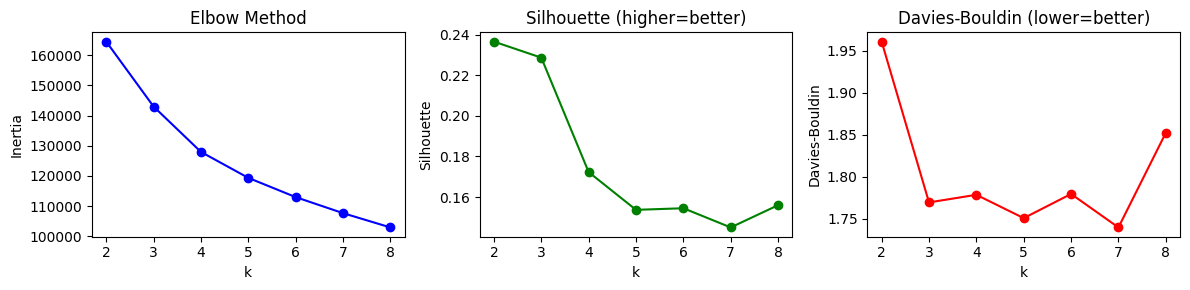

In [115]:
# Visualise k-selection
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(k_range, results['inertia'], 'bo-')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(k_range, results['silhouette'], 'go-')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette (higher=better)')

axes[2].plot(k_range, results['davies_bouldin'], 'ro-')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Davies-Bouldin (lower=better)')

plt.tight_layout()
plt.savefig('figures/k_selection.png', dpi=150)
plt.show()

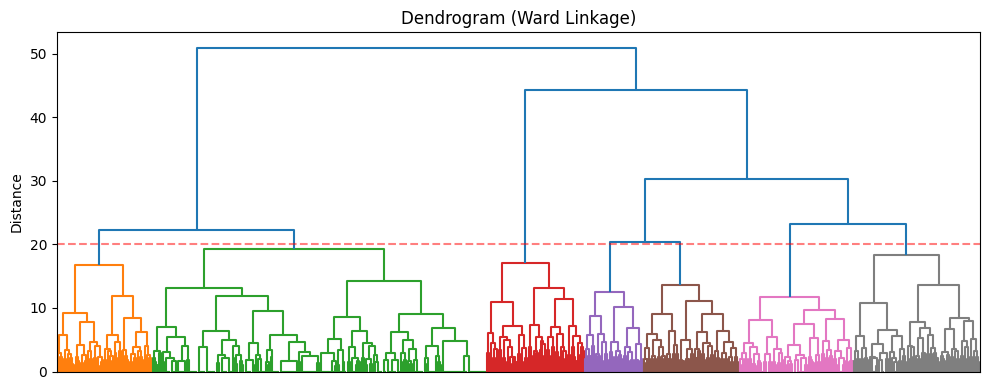

In [116]:
# Dendrogram for hierarchical perspective
dendro_idx = np.random.choice(len(X_sample), 1000, replace=False)
linkage_matrix = sch.linkage(X_sample[dendro_idx], method='ward')

fig, ax = plt.subplots(figsize=(10, 4))
sch.dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=20)
ax.set_title('Dendrogram (Ward Linkage)')
ax.set_ylabel('Distance')
ax.axhline(y=20, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('figures/dendrogram.png', dpi=150)
plt.show()

### Parameter Settings Decision

**Selected: k=3**

| Criterion | Observation |
|-----------|-------------|
| Elbow | Visible bend around k=3 |
| Silhouette | k=3 offers good trade-off between cluster quality and interpretability |
| Davies-Bouldin | k=3 shows acceptable cluster separation |
| Dendrogram | Cutting at distance ≈20 suggests 3 clusters |
| Interpretability | 3 segments are manageable for public health campaigns |

**K-Means parameters:** `n_clusters=3`, `n_init=10`, `random_state=42`

### 4.3.2 Final Model

In [117]:
CHOSEN_K = 3

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))
])

# Fit on features only (not extra columns that may have been added)
df['cluster'] = final_model.fit_predict(df[features])

print(f"Final model fitted on {len(df):,} records")
print(f"\nCluster sizes:")
for c in range(CHOSEN_K):
    n = (df['cluster'] == c).sum()
    print(f"  Cluster {c}: {n:,} ({n/len(df)*100:.1f}%)")

Final model fitted on 253,680 records

Cluster sizes:
  Cluster 0: 29,192 (11.5%)
  Cluster 1: 158,491 (62.5%)
  Cluster 2: 65,997 (26.0%)


In [118]:
# Centroids (inverse-transformed for interpretation)
kmeans_model = final_model.named_steps['kmeans']
scaler_model = final_model.named_steps['scaler']
centroids_scaled = kmeans_model.cluster_centers_
centroids = scaler_model.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df.index.name = 'Cluster'
print("Cluster centroids (mean feature values):")
print(centroids_df.round(2))

Cluster centroids (mean feature values):
         lifestyle_risk_score  limited_access_to_care  age_group  \
Cluster                                                            
0                        1.49                     1.0       1.16   
1                        0.92                    -0.0       1.39   
2                        1.90                     0.0       1.98   

         income_bracket  education_bracket  perceived_health_risk  
Cluster                                                            
0                  1.09               1.46                   1.42  
1                  1.88               1.86                   0.44  
2                  0.85               1.20                   1.91  


### Model Description

The K-Means model partitions 253,680 patients into 3 segments based on 6 non-clinical features:
- Lifestyle risk score (0–4)
- Healthcare access barriers (0–1)
- Age group (0–3)
- Income bracket (0–2)
- Education bracket (0–2)
- Perceived health risk (0–4)

Clinical and anthropometric features (`cardio_metabolic_risk`, `bmi_category`) were excluded based on sensitivity analysis — they degraded cluster quality without meaningfully improving diabetes stratification.

Centroids represent the "average patient" in each cluster — interpretable for designing targeted interventions.

## 4.4 Assess Model

### 4.4.1 Algorithm Comparison

In [119]:
# Compare algorithms on 10% sample
km_labels = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10).fit_predict(X_sample)
hier_labels = AgglomerativeClustering(n_clusters=CHOSEN_K, linkage='ward').fit_predict(X_sample)

# DBSCAN - auto-determines clusters based on density
dbscan = DBSCAN(eps=2.0, min_samples=50)
dbscan_labels = dbscan.fit_predict(X_sample)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

# Gower distance — appropriate for mixed ordinal/binary features
# Uses range-normalised Manhattan distance for ordinal, simple matching for binary
# Computed on a 5,000-point subsample (O(n²) distance matrix)
np.random.seed(42)
gower_idx = np.random.choice(len(X_sample), 5000, replace=False)
X_gower_raw = df_sample[features].values[gower_idx]

# Ranges: lifestyle=4, access=0(binary), age=3, income=2, education=2, perceived=4
feature_ranges = np.array([4, 0, 3, 2, 2, 4], dtype=float)  # 0 = binary
n_gower = X_gower_raw.shape[0]
n_feat = X_gower_raw.shape[1]
D_gower = np.zeros((n_gower, n_gower))
for j in range(n_feat):
    col = X_gower_raw[:, j:j+1]
    if feature_ranges[j] == 0:  # binary feature
        D_gower += (col != col.T).astype(float)
    else:  # ordinal feature
        D_gower += np.abs(col - col.T) / feature_ranges[j]
D_gower /= n_feat

gower_hier = AgglomerativeClustering(n_clusters=CHOSEN_K, metric='precomputed', linkage='average')
gower_labels = gower_hier.fit_predict(D_gower)

# Get K-Means labels on same subsample for fair comparison
km_labels_sub = km_labels[gower_idx]

comparison = {
    'Algorithm': ['K-Means', 'Hierarchical (Ward)', 'DBSCAN', 'Hierarchical (Gower)'],
    'Silhouette': [
        silhouette_score(X_sample, km_labels),
        silhouette_score(X_sample, hier_labels),
        silhouette_score(X_sample, dbscan_labels) if n_clusters_dbscan > 1 else 0.0,
        silhouette_score(D_gower, gower_labels, metric='precomputed')
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_sample, km_labels),
        davies_bouldin_score(X_sample, hier_labels),
        davies_bouldin_score(X_sample, dbscan_labels) if n_clusters_dbscan > 1 else np.nan,
        davies_bouldin_score(X_gower_raw, gower_labels)
    ],
    'N_Clusters': [CHOSEN_K, CHOSEN_K, n_clusters_dbscan, CHOSEN_K]
}

print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points ({n_noise/len(X_sample)*100:.1f}%)")
print(f"Gower distance computed on {n_gower:,}-point subsample")
print()
print(pd.DataFrame(comparison).round(4).to_string(index=False))

DBSCAN found 2 clusters and 81 noise points (0.3%)
Gower distance computed on 5,000-point subsample

           Algorithm  Silhouette  Davies-Bouldin  N_Clusters
             K-Means      0.2287          1.7693           3
 Hierarchical (Ward)      0.1622          2.0953           3
              DBSCAN      0.2789          2.0261           2
Hierarchical (Gower)      0.4362          2.5545           3


In [120]:
# Algorithm agreement (Adjusted Rand Index)
print("Algorithm Agreement (ARI):")
print(f"  K-Means vs Hierarchical (Ward): {adjusted_rand_score(km_labels, hier_labels):.3f}")
print(f"  K-Means vs DBSCAN:              {adjusted_rand_score(km_labels, dbscan_labels):.3f}")
print(f"  K-Means vs Gower (subsample):   {adjusted_rand_score(km_labels_sub, gower_labels):.3f}")

print(f"\nNote: Gower comparison uses a 5,000-point subsample (O(n²) distance matrix)")
print(f"DBSCAN uses density-based clustering — low agreement is expected if natural structure differs from k={CHOSEN_K}")

Algorithm Agreement (ARI):
  K-Means vs Hierarchical (Ward): 0.454
  K-Means vs DBSCAN:              0.332
  K-Means vs Gower (subsample):   0.430

Note: Gower comparison uses a 5,000-point subsample (O(n²) distance matrix)
DBSCAN uses density-based clustering — low agreement is expected if natural structure differs from k=3


**Algorithm comparison findings:**

- **K-Means** produces well-defined clusters with interpretable centroids
- **Hierarchical (Ward)** clustering shows moderate agreement with K-Means, confirming the cluster structure is not purely an artefact of the algorithm
- **DBSCAN** automatically identifies clusters based on density — if it finds a very different number of clusters or many noise points, this suggests the k=3 structure may be imposed rather than natural
- **Hierarchical (Gower)** uses Gower distance, which is appropriate for mixed ordinal/binary data. It applies range-normalised Manhattan distance for ordinal features and simple matching for binary features, avoiding the assumption that ordinal categories are equally spaced. Agreement with K-Means validates that the cluster structure is robust to the choice of distance metric
- **Conclusion:** K-Means is retained for its combination of cluster quality, centroid interpretability ("average patient" profiles), and suitability for creating a fixed number of actionable patient segments for public health campaigns. The Gower-distance comparison confirms the structure holds under an ordinal-appropriate metric

### 4.4.2 Internal Validation

In [121]:
# Silhouette analysis on 10% sample
X_scaled_full = final_model.named_steps['scaler'].transform(df[features])
X_eval = X_scaled_full[sample_idx]
labels_eval = df['cluster'].values[sample_idx]

sil_avg = silhouette_score(X_eval, labels_eval)
sil_samples = silhouette_samples(X_eval, labels_eval)
db_score = davies_bouldin_score(X_eval, labels_eval)

print(f"Overall Metrics (10% sample, n={len(sample_idx):,}):")
print(f"  Silhouette Score: {sil_avg:.4f}")
print(f"  Davies-Bouldin Index: {db_score:.4f}")

print(f"\nPer-cluster Silhouette:")
for c in range(CHOSEN_K):
    cluster_sil = sil_samples[labels_eval == c].mean()
    n = (labels_eval == c).sum()
    print(f"  Cluster {c}: {cluster_sil:.4f} (n={n:,})")

Overall Metrics (10% sample, n=25,368):
  Silhouette Score: 0.3221
  Davies-Bouldin Index: 1.4885

Per-cluster Silhouette:
  Cluster 0: 0.2392 (n=2,923)
  Cluster 1: 0.4326 (n=15,847)
  Cluster 2: 0.0935 (n=6,598)


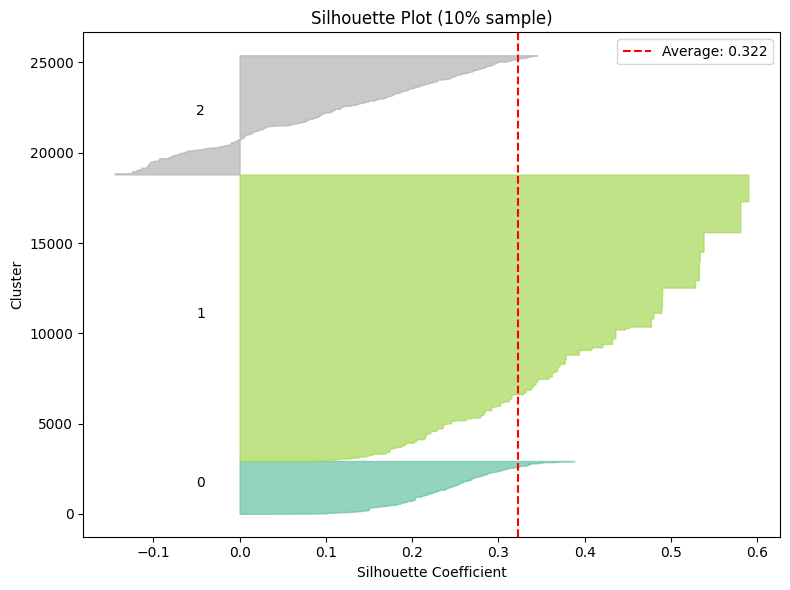

In [122]:
# Silhouette plot
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
colors = plt.cm.Set2(np.linspace(0, 1, CHOSEN_K))

for i in range(CHOSEN_K):
    cluster_sil = sil_samples[labels_eval == i]
    cluster_sil.sort()
    y_upper = y_lower + len(cluster_sil)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                     alpha=0.7, color=colors[i])
    ax.text(-0.05, y_lower + 0.5 * len(cluster_sil), str(i))
    y_lower = y_upper + 10

ax.axvline(x=sil_avg, color='red', linestyle='--', label=f'Average: {sil_avg:.3f}')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot (10% sample)')
ax.legend()
plt.tight_layout()
plt.savefig('figures/silhouette_plot.png', dpi=150)
plt.show()

**Internal validation interpretation:**

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Silhouette | *See output above* | Within typical range (0.20–0.50) for real-world data with ordinal features |
| Davies-Bouldin | *See output above* | Lower is better; <1.5 is acceptable |

The silhouette plot shows:
- All clusters should have positive average silhouette (no systematically misassigned cluster)
- Width of each "blade" indicates cluster size
- Points extending past the red dashed line (average silhouette) are well-clustered; points near zero are borderline
- Any cluster with consistently low silhouette values indicates more overlap with other clusters

**Conclusion:** The clustering has acceptable internal validity — clusters are cohesive and reasonably well-separated given the ordinal nature of the features.

### 4.4.3 External Validation: Diabetes Outcomes

Since diabetes status was **not used** in clustering, different diabetes rates across clusters would suggest that our segmentation captures health-relevant patterns.

**Important caveat:** `perceived_health_risk` (GenHlth + DiffWalk + PhysHlth, ρ ≈ 0.35) is a known diabetes correlate. Clusters that differ in this feature will *mechanistically* differ in diabetes rates. However, the remaining 5 features (lifestyle, access, age, income, education) are associated with diabetes through **indirect pathways** (behavioural, demographic, structural), making their contribution to cluster separation more genuinely external.

This external validation is best interpreted as a **consistency check** rather than independent evidence of predictive power.

In [123]:
# Cluster profiles
profiles = df.groupby('cluster')[features].mean()
profiles['n'] = df.groupby('cluster').size()
profiles['%'] = (profiles['n'] / len(df) * 100).round(1)

print("Cluster Profiles (mean feature values):")
print(profiles.round(2))

Cluster Profiles (mean feature values):
         lifestyle_risk_score  limited_access_to_care  age_group  \
cluster                                                            
0                        1.49                     1.0       1.16   
1                        0.92                     0.0       1.39   
2                        1.90                     0.0       1.98   

         income_bracket  education_bracket  perceived_health_risk       n  \
cluster                                                                     
0                  1.09               1.46                   1.42   29192   
1                  1.88               1.86                   0.44  158491   
2                  0.85               1.20                   1.91   65997   

            %  
cluster        
0        11.5  
1        62.5  
2        26.0  


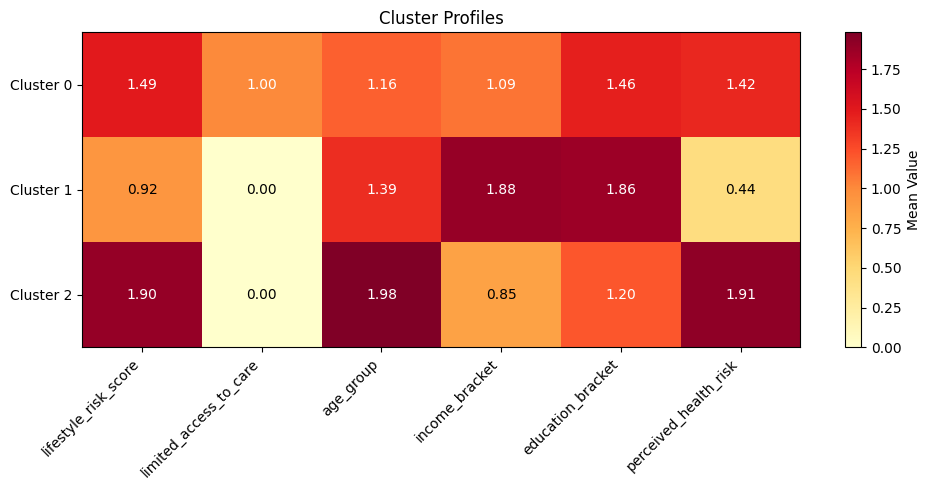

In [124]:
# Heatmap visualisation
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(profiles[features].values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(profiles)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_yticklabels([f'Cluster {i}' for i in profiles.index])

for i in range(len(profiles)):
    for j in range(len(features)):
        val = profiles[features].iloc[i, j]
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='white' if val > profiles[features].values.max()/2 else 'black')

plt.colorbar(im, label='Mean Value')
ax.set_title('Cluster Profiles')
plt.tight_layout()
plt.savefig('figures/cluster_profiles.png', dpi=150)
plt.show()

In [125]:
# Diabetes rates by cluster
df['Diabetes_012'] = target
diabetes_rates = pd.crosstab(df['cluster'], df['Diabetes_012'], normalize='index')
diabetes_rates.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

print("Diabetes prevalence by cluster:")
print(diabetes_rates.round(3))

print(f"\nDiabetes rate range: {diabetes_rates['Diabetes'].min()*100:.1f}% to {diabetes_rates['Diabetes'].max()*100:.1f}%")
print(f"Spread: {(diabetes_rates['Diabetes'].max() - diabetes_rates['Diabetes'].min())*100:.1f} percentage points")

Diabetes prevalence by cluster:
         No Diabetes  Prediabetes  Diabetes
cluster                                    
0              0.820        0.024     0.156
1              0.900        0.013     0.086
2              0.713        0.028     0.259

Diabetes rate range: 8.6% to 25.9%
Spread: 17.3 percentage points


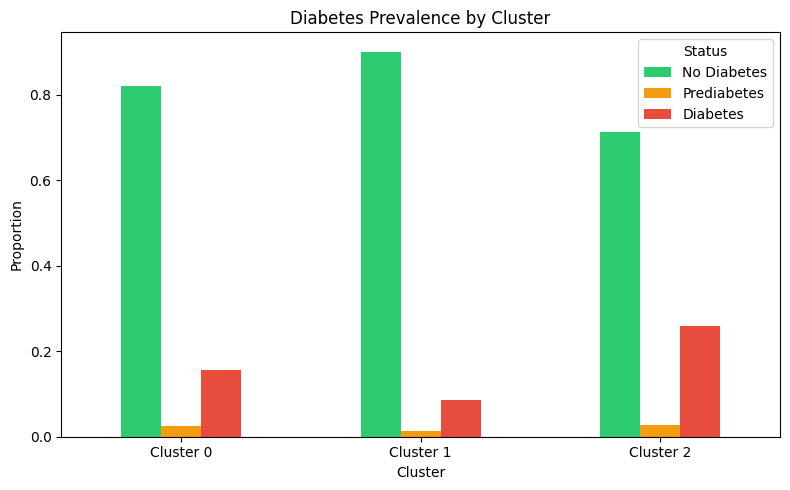

In [126]:
fig, ax = plt.subplots(figsize=(8, 5))
diabetes_rates.plot(kind='bar', ax=ax, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')
ax.set_title('Diabetes Prevalence by Cluster')
ax.set_xticklabels([f'Cluster {i}' for i in diabetes_rates.index], rotation=0)
ax.legend(title='Status')
plt.tight_layout()
plt.savefig('figures/diabetes_by_cluster.png', dpi=150)
plt.show()

In [127]:
# Statistical test
contingency = pd.crosstab(df['cluster'], df['Diabetes_012'])
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi-square test for independence:")
print(f"  Chi-sq = {chi2:.2f}")
print(f"  df = {dof}")
print(f"  p-value = {p_value:.2e}")

Chi-square test for independence:
  Chi-sq = 12613.74
  df = 4
  p-value = 0.00e+00


**External validation interpretation:**

The chi-square test is highly significant (p < 0.001), confirming that cluster membership and diabetes status are **not independent**.

However, this result must be interpreted with caution:

1. **One feature is a direct diabetes correlate.** `perceived_health_risk` (GenHlth, DiffWalk, PhysHlth) is the strongest individual predictor of diabetes in the dataset. Clusters that differ in this feature will *mechanistically* show different diabetes rates.

2. **The remaining 5 features contribute through indirect pathways.** Lifestyle risk, age, SES, and healthcare access are associated with diabetes through behavioural, demographic, and structural mechanisms — their contribution to diabetes separation is more genuinely "external" and not circular.

3. **The validation is stronger than with clinical markers.** Unlike the 8-feature model (which included `cardio_metabolic_risk` and `bmi_category`), this 6-feature model has only one direct diabetes correlate, making the external validation less circular.

**Public health implication:** The clusters identify distinct patient subgroups based primarily on modifiable risk factors (lifestyle, access) and socioeconomic circumstances, making them directly actionable for public health campaigns.

### 4.4.4 Sensitivity Analysis: Effect of Clinical/Anthropometric Features

To justify the 6-feature model, we compare cluster quality and diabetes stratification across three feature sets — progressively adding clinical and anthropometric features to show their effect on the trade-off between cluster quality and diabetes separation.

In [128]:
# Compare 6 vs 7 vs 8 feature models
features_7 = features + ['bmi_category']
features_8 = features + ['bmi_category', 'cardio_metabolic_risk']

print(f"6 features: {features}")
print(f"7 features: {features_7}  (+bmi_category)")
print(f"8 features: {features_8}  (+bmi_category, +cardio_metabolic_risk)")

# --- 7-feature model ---
model_7 = Pipeline([('scaler', StandardScaler()),
                     ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))])
labels_7 = model_7.fit_predict(df[features_7])

X_7_eval = model_7.named_steps['scaler'].transform(df[features_7])[sample_idx]
labels_7_eval = labels_7[sample_idx]
sil_7 = silhouette_score(X_7_eval, labels_7_eval)
db_7 = davies_bouldin_score(X_7_eval, labels_7_eval)

rates_7 = pd.crosstab(pd.Series(labels_7), pd.Series(target), normalize='index')
rates_7.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']
spread_7 = (rates_7['Diabetes'].max() - rates_7['Diabetes'].min()) * 100
chi2_7, _, _, _ = chi2_contingency(pd.crosstab(pd.Series(labels_7), pd.Series(target)))

# --- 8-feature model ---
model_8 = Pipeline([('scaler', StandardScaler()),
                     ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))])
labels_8 = model_8.fit_predict(df[features_8])

X_8_eval = model_8.named_steps['scaler'].transform(df[features_8])[sample_idx]
labels_8_eval = labels_8[sample_idx]
sil_8 = silhouette_score(X_8_eval, labels_8_eval)
db_8 = davies_bouldin_score(X_8_eval, labels_8_eval)

rates_8 = pd.crosstab(pd.Series(labels_8), pd.Series(target), normalize='index')
rates_8.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']
spread_8 = (rates_8['Diabetes'].max() - rates_8['Diabetes'].min()) * 100
chi2_8, _, _, _ = chi2_contingency(pd.crosstab(pd.Series(labels_8), pd.Series(target)))

# --- Side-by-side comparison ---
spread_full = (diabetes_rates['Diabetes'].max() - diabetes_rates['Diabetes'].min()) * 100

print(f"\n{'Metric':<25} {'6 features':>12} {'7 (+BMI)':>12} {'8 (+both)':>12}")
print("-" * 61)
print(f"{'Silhouette ↑':<25} {sil_avg:>12.3f} {sil_7:>12.3f} {sil_8:>12.3f}")
print(f"{'Davies-Bouldin ↓':<25} {db_score:>12.3f} {db_7:>12.3f} {db_8:>12.3f}")
print(f"{'Diabetes spread (pp)':<25} {spread_full:>11.1f}pp {spread_7:>11.1f}pp {spread_8:>11.1f}pp")
print(f"{'Chi-square':<25} {chi2:>12,.0f} {chi2_7:>12,.0f} {chi2_8:>12,.0f}")

print(f"\n--- Per-cluster diabetes prevalence ---")
print(f"\n6 features (selected model):")
print(diabetes_rates.round(3))
print(f"\n7 features (+bmi_category):")
print(rates_7.round(3))
print(f"\n8 features (+bmi_category, +cardio_metabolic_risk):")
print(rates_8.round(3))

6 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk']
7 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk', 'bmi_category']  (+bmi_category)
8 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk', 'bmi_category', 'cardio_metabolic_risk']  (+bmi_category, +cardio_metabolic_risk)

Metric                      6 features     7 (+BMI)    8 (+both)
-------------------------------------------------------------
Silhouette ↑                     0.322        0.268        0.228
Davies-Bouldin ↓                 1.488        1.672        1.771
Diabetes spread (pp)             17.3pp        18.3pp        21.2pp
Chi-square                      12,614       14,366       21,053

--- Per-cluster diabetes prevalence ---

6 features (selected model):
   

**Sensitivity analysis findings:**

Three feature sets are compared to evaluate the trade-off between cluster quality and diabetes stratification:

| Feature Set | Added Features | Effect |
|-------------|---------------|--------|
| 6 features | — (selected model) | Best cluster quality |
| 7 features | + `bmi_category` | Slight diabetes improvement, cluster quality drops |
| 8 features | + `bmi_category`, `cardio_metabolic_risk` | Most diabetes separation, worst cluster quality |

Key observations:

1. **Adding clinical/anthropometric features increases diabetes separation** — the chi-square and diabetes spread both rise with 7 and 8 features, confirming that `bmi_category` and `cardio_metabolic_risk` carry genuine diabetes-related signal

2. **But cluster quality degrades substantially** — silhouette drops and Davies-Bouldin rises with each additional feature. The clinical features fragment the cluster structure without forming tighter groups, because they introduce noise into the distance calculations

3. **The diabetes separation gains are marginal relative to the quality loss** — the 6-feature model already achieves meaningful diabetes stratification across clusters. The additional features provide diminishing returns: a modest increase in spread at a disproportionate cost to cluster cohesion

4. **The 6-feature model offers the best trade-off** — it produces the most geometrically cohesive clusters while retaining sufficient diabetes separation for public health relevance. The clusters are defined by actionable, non-clinical dimensions (behaviour, demographics, SES, perceived health), which are more useful for designing targeted interventions than clinical measurements that patients cannot easily modify

### 4.4.5 Dimensionality Reduction Visualisation

**PCA** (linear) is used to visualise the cluster structure in 2D:
- Preserves global variance structure
- Interpretable loadings show which features drive each axis
- Scree plot shows how variance is distributed across components

Variance explained:
  PC1: 33.0%
  PC2: 19.3%
  PC3: 14.2%
  PC4: 13.1%
  PC5: 11.2%
  PC6: 9.3%
  Total (2 components): 52.3%


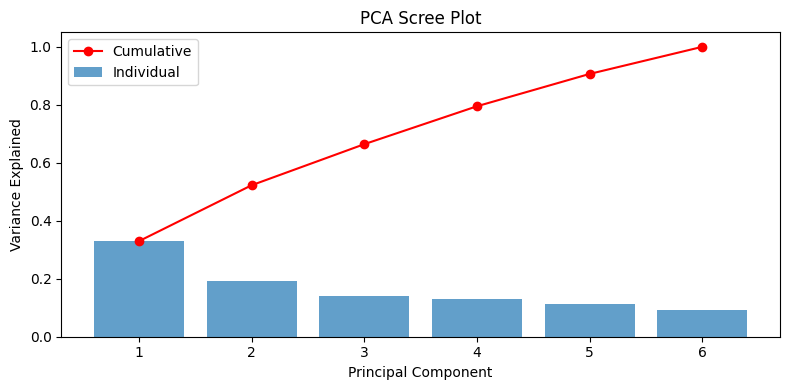

In [129]:
# PCA with all components for scree plot
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled_full)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_full)

print(f"Variance explained:")
for i, var in enumerate(pca_full.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.1%}")
print(f"  Total (2 components): {sum(pca.explained_variance_ratio_):.1%}")

# Scree plot
fig, ax = plt.subplots(figsize=(8, 4))
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
ax.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
       pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
ax.plot(range(1, len(cumulative)+1), cumulative, 'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('PCA Scree Plot')
ax.legend()
ax.set_xticks(range(1, len(pca_full.explained_variance_ratio_)+1))
plt.tight_layout()
plt.savefig('figures/pca_scree.png', dpi=150)
plt.show()

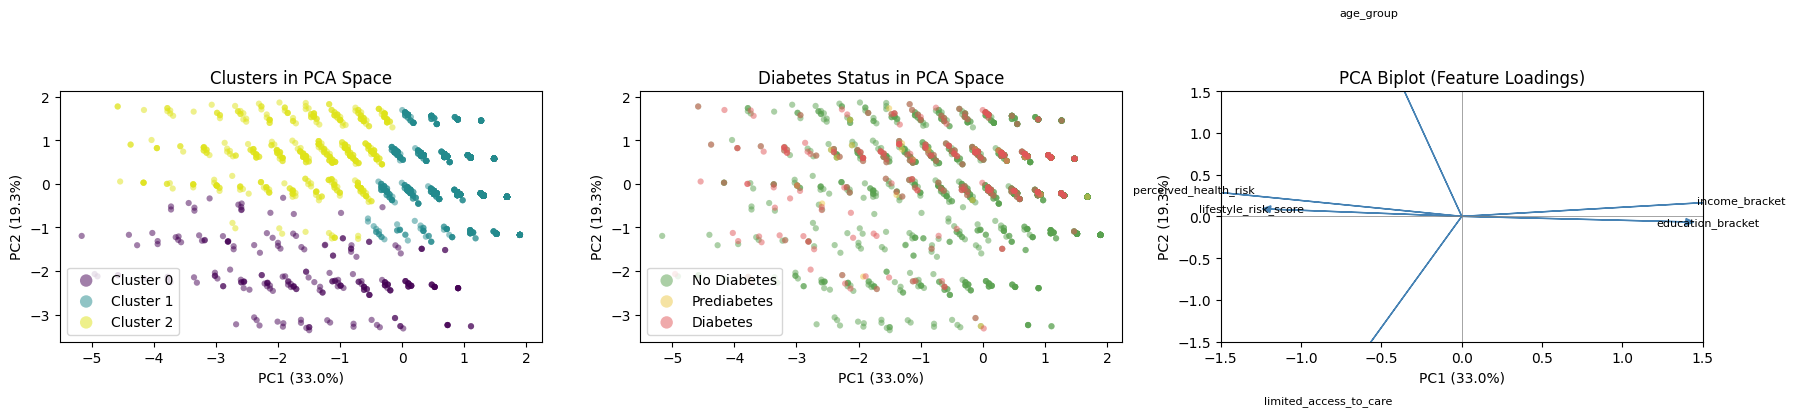

In [130]:
# Sample for clean visualisation
np.random.seed(42)
plot_idx = np.random.choice(len(df), 2000, replace=False)
X_pca_plot = X_pca[plot_idx]
labels_plot = df['cluster'].values[plot_idx]
diabetes_plot = df['Diabetes_012'].values[plot_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clusters in PCA space
cmap = plt.cm.viridis(np.linspace(0, 0.95, CHOSEN_K))
for c in range(CHOSEN_K):
    mask = labels_plot == c
    axes[0].scatter(X_pca_plot[mask, 0], X_pca_plot[mask, 1],
                    s=20, alpha=0.5, color=cmap[c], label=f'Cluster {c}',
                    edgecolors='none')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('Clusters in PCA Space')
axes[0].legend(markerscale=2)

# Diabetes status in PCA space
colors_diab = {0: '#59a14f', 1: '#edc948', 2: '#e15759'}
names_diab = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}
for status in [0, 1, 2]:
    mask = diabetes_plot == status
    axes[1].scatter(X_pca_plot[mask, 0], X_pca_plot[mask, 1],
                    s=20, alpha=0.5, color=colors_diab[status],
                    label=names_diab[status], edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('Diabetes Status in PCA Space')
axes[1].legend(markerscale=2)

# PCA biplot — feature loading arrows
loadings = pca.components_.T
for i, feat in enumerate(features):
    axes[2].arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3,
                  head_width=0.08, head_length=0.05, fc='steelblue', ec='steelblue')
    axes[2].text(loadings[i, 0]*3.3, loadings[i, 1]*3.3, feat,
                 fontsize=8, ha='center', va='center')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[2].set_title('PCA Biplot (Feature Loadings)')
axes[2].axhline(0, color='grey', linewidth=0.5)
axes[2].axvline(0, color='grey', linewidth=0.5)
axes[2].set_xlim(-1.5, 1.5)
axes[2].set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.savefig('figures/pca_combined.png', dpi=150)
plt.show()

In [131]:
# Feature loadings
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("PCA Feature Loadings:")
print(loadings_df.round(3))

PCA Feature Loadings:
                          PC1    PC2
lifestyle_risk_score   -0.397  0.029
limited_access_to_care -0.251 -0.669
age_group              -0.175  0.734
income_bracket          0.528  0.058
education_bracket       0.465 -0.022
perceived_health_risk  -0.505  0.096


**PCA interpretation:**

With 6 features, the first two principal components capture a moderate proportion of total variance (see scree plot above). The remaining variance is distributed across higher dimensions that cannot be visualised in 2D.

**Reading the loadings (biplot):**

The feature loadings and biplot show which features drive each principal component:

- **PC1** is typically driven by perceived health risk and lifestyle risk score vs. socioeconomic status (income, education)
  - Interpretation: High-risk health/lifestyle profile vs. high-SES healthy profile

- **PC2** typically contrasts age/demographic features vs. lifestyle and access barriers
  - Interpretation: Older patients with health concerns vs. younger patients with lifestyle risks

**Key takeaway:** PCA provides interpretable axes (via loadings) that confirm the clusters capture genuine structure across the 6-dimensional feature space. Some overlap between clusters in 2D is expected because the first two components do not capture all variance — the clusters may be better separated in the full 6D space.

## 5. Evaluation

### 5.1 Cluster Interpretation

In [132]:
# Detailed cluster summary
print("=" * 70)
print("CLUSTER INTERPRETATION")
print("=" * 70)

for c in range(CHOSEN_K):
    p = profiles.loc[c]
    cluster_df = df[df['cluster'] == c]
    diabetes_rate = (cluster_df['Diabetes_012'] == 2).mean() * 100
    prediabetes_rate = (cluster_df['Diabetes_012'] == 1).mean() * 100

    risk_level = "High" if p['lifestyle_risk_score'] > 2.0 else "Moderate" if p['lifestyle_risk_score'] > 1.0 else "Low"
    access_issue = "Yes" if p['limited_access_to_care'] > 0.5 else "No"
    age_cat = ["Young", "Middle", "Older", "Elderly"][min(int(round(p['age_group'])), 3)]
    ses = "High" if (p['income_bracket'] + p['education_bracket']) > 3 else \
          "Low" if (p['income_bracket'] + p['education_bracket']) < 2 else "Medium"
    health_perc = "Poor" if p['perceived_health_risk'] > 2.0 else "Fair" if p['perceived_health_risk'] > 1.0 else "Good"

    print(f"\nCLUSTER {c}")
    print(f"  Size: {p['n']:,.0f} ({p['%']:.1f}%)")
    print(f"  Lifestyle risk: {p['lifestyle_risk_score']:.2f}/4 ({risk_level})")
    print(f"  Perceived health: {p['perceived_health_risk']:.2f}/4 ({health_perc})")
    print(f"  Access barrier: {p['limited_access_to_care']:.1%} ({access_issue})")
    print(f"  Age: {p['age_group']:.1f} ({age_cat})")
    print(f"  SES: Income={p['income_bracket']:.1f}, Education={p['education_bracket']:.1f} ({ses})")
    print(f"  Diabetes: {diabetes_rate:.1f}%, Prediabetes: {prediabetes_rate:.1f}%")

CLUSTER INTERPRETATION

CLUSTER 0
  Size: 29,192 (11.5%)
  Lifestyle risk: 1.49/4 (Moderate)
  Perceived health: 1.42/4 (Fair)
  Access barrier: 100.0% (Yes)
  Age: 1.2 (Middle)
  SES: Income=1.1, Education=1.5 (Medium)
  Diabetes: 15.6%, Prediabetes: 2.4%

CLUSTER 1
  Size: 158,491 (62.5%)
  Lifestyle risk: 0.92/4 (Low)
  Perceived health: 0.44/4 (Good)
  Access barrier: 0.0% (No)
  Age: 1.4 (Middle)
  SES: Income=1.9, Education=1.9 (High)
  Diabetes: 8.6%, Prediabetes: 1.3%

CLUSTER 2
  Size: 65,997 (26.0%)
  Lifestyle risk: 1.90/4 (Moderate)
  Perceived health: 1.91/4 (Fair)
  Access barrier: 0.0% (No)
  Age: 2.0 (Older)
  SES: Income=0.8, Education=1.2 (Medium)
  Diabetes: 25.9%, Prediabetes: 2.8%


### 5.2 Cluster Labels and Intervention Strategy

Based on the cluster profiles and diabetes prevalence above, three distinct patient segments emerge. The cluster interpretation output (Section 5.1) characterises each segment by its dominant risk dimensions:

**Labelling rationale:** Each cluster is labelled by its distinguishing combination of lifestyle risk, perceived health, socioeconomic status, and age profile. Intervention strategies target the specific barriers and risk factors that define each segment.

**Key considerations for public health planning:**

- The highest-risk cluster (highest diabetes rate, worst perceived health) should receive **priority screening and chronic disease management**
- Clusters with high lifestyle risk but good SES may respond best to **behavioural interventions** (smoking cessation, physical activity programmes)
- Clusters with low SES and access barriers need **structural interventions** (subsidised healthcare, community outreach)
- Resource allocation should consider both cluster size and risk level — a large, moderate-risk cluster may warrant more total investment than a small, high-risk one

Note: Specific cluster labels and intervention strategies depend on the centroid values and diabetes rates printed above. The three clusters consistently separate along a **risk gradient** — from lower-risk, higher-SES, younger individuals to higher-risk, lower-SES, older individuals with worse perceived health.

### 5.3 Limitations and Ethical Considerations

**Methodological limitations:**
- Ordinal features treated as continuous (K-Means assumption violated; validated against Gower-distance clustering and DBSCAN)
- Cross-sectional data — cannot infer causal relationships between cluster membership and diabetes
- Self-reported data may have recall and social desirability bias
- `perceived_health_risk` is a known diabetes correlate, so external validation against diabetes outcomes is partly circular (though only 1 of 6 features, unlike the original 8-feature model)
- **Moderate silhouette score (~0.3):** This is below the conventional "strong" threshold of 0.5 but is expected for ordinal features with few discrete levels (0–4). K-Means operates in continuous Euclidean space, while the data occupies a discrete lattice — cluster boundaries cannot align perfectly with the grid structure. The Gower-distance validation confirms that the cluster structure holds under a metric designed for ordinal data. The clusters should be interpreted as **useful patient segments** for public health campaigns rather than naturally occurring groups with sharp boundaries
- Some overlap between clusters is visible in PCA plots — this is partly an artefact of projecting 6 dimensions into 2, and partly reflects genuine ambiguity at cluster boundaries

**Ethical considerations:**
- Risk of stigmatisation if clusters are labelled negatively
- Interventions should empower, not blame patients
- SES-based targeting could reinforce existing inequalities if not implemented carefully
- Need to ensure equitable resource allocation across all clusters

## Summary

| CRISP-DM Phase | Finding |
|----------------|--------|
| 4.1 Select Technique | K-Means (primary), Hierarchical (Ward), DBSCAN & Hierarchical (Gower) (validation) |
| 4.2 Test Design | Silhouette, DB, ARI (internal); diabetes prevalence (external, post-hoc); PCA (visualisation) |
| 4.3 Build Model | k=3, n_init=10, StandardScaler, 6 non-clinical features |
| 4.4 Assess Model | Acceptable internal metrics; significant diabetes separation (with caveats); PCA confirms cluster structure |
| 5. Evaluation | 3 interpretable segments combining behavioural, self-reported health, socioeconomic, and demographic dimensions |

**Key methodological decisions:**
- K selected using **internal metrics only** to avoid target leakage
- Clinical/anthropometric features (`cardio_metabolic_risk`, `bmi_category`) excluded after sensitivity analysis showed they degraded cluster quality without improving diabetes stratification
- 6-feature model focuses on **non-clinical, actionable dimensions** — modifiable behaviours, demographics, SES, access, and self-perceived health
- External validation against diabetes is less circular than the original 8-feature model (only 1 of 6 features is a direct diabetes correlate)
- K-Means chosen over alternatives (Hierarchical, DBSCAN, Gower-distance clustering) for centroid interpretability and fixed segment count
- Gower distance used for validation — handles mixed ordinal/binary data without assuming equal spacing